In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import noisereduce as nr
import IPython
torch.manual_seed(10)

/anaconda/envs/py36/lib/python3.6/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
BASE = '/data/home/advaitmb/datasets/sentences/'

In [3]:
import pandas as pd
audio = pd.read_csv('audio_df_improvised.csv')

audio.reset_index(inplace=True)
audio.head()

,index,start_time,end_time,wav_file,emotion,val,act,dom
0,0,6.2901,8.2357,Ses01F_impro01_F000,neu,2.5,2.5,2.5
1,1,10.0100,11.3925,Ses01F_impro01_F001,neu,2.5,2.5,2.5
2,2,14.8872,18.0175,Ses01F_impro01_F002,neu,2.5,2.5,2.5
3,3,27.4600,31.4900,Ses01F_impro01_F005,neu,2.5,3.5,2.0
4,4,85.2700,88.0200,Ses01F_impro01_F012,ang,2.0,3.5,3.5


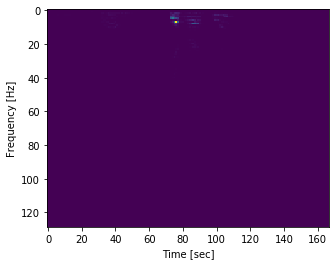

array([[4.9540834e+00, 1.3929467e+00, 1.7555124e-01, ..., 2.6783612e-01,
        3.2297209e-01, 1.8852812e-01],
       [8.0558860e-01, 2.7288103e+01, 1.5808014e+00, ..., 7.2865702e-02,
        3.7659515e+01, 2.5938410e+01],
       [9.2334641e+01, 3.2209969e+01, 2.1711199e+01, ..., 4.2785553e+01,
        5.9137988e+00, 6.2987185e+00],
       ...,
       [2.9528293e-05, 8.7063536e-06, 2.6570602e-05, ..., 3.8541766e-06,
        2.0493972e-05, 4.3956220e-06],
       [9.3047584e-06, 3.5067612e-07, 2.5598016e-05, ..., 5.2366113e-06,
        2.1329264e-05, 6.7887195e-06],
       [8.3403870e-07, 2.3460029e-06, 1.9754012e-07, ..., 4.1959397e-06,
        1.1236058e-05, 2.4576315e-05]], dtype=float32)

In [73]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read(BASE+audio['wav_file'][100]+'.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
spectrogram

(65, 128)


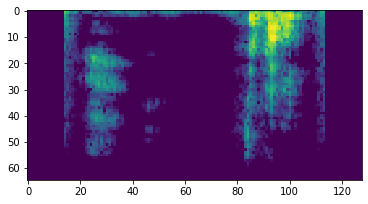

In [8]:
med_duration=4
wav,sr = librosa.load(BASE+audio['wav_file'][2]+'.wav',sr=None)
wav = nr.reduce_noise(audio_clip=wav, noise_clip=wav, verbose=False)
if wav.shape[0]<(med_duration*sr):
    wav=np.pad(wav,int( np.ceil( ((med_duration*sr)-wav.shape[0])/2 ) ),mode='constant', constant_values=(0, 0))
else:
    wav=wav[:(med_duration*sr)]


D = np.abs(librosa.stft(wav, hop_length=501, n_fft=128))
D_db = librosa.amplitude_to_db(D)
print(D_db.shape)
plt.imshow(D_db)

In [55]:
base = '/data/home/advaitmb/datasets/sentences/'
med_duration=4
wav,sr = librosa.load(base+audio['wav_file'][2]+'.wav',sr=None)

if wav.shape[0]<(med_duration*sr):
    wav=np.pad(wav,int( np.ceil( ((med_duration*sr)-wav.shape[0])/2 ) ),mode='constant', constant_values=(0, 0))
else:
    wav=wav[:(med_duration*sr)]
wav = nr.reduce_noise(audio_clip=wav, noise_clip=wav, verbose=False)

IPython.display.Audio(data=wav, rate=sr)

In [4]:
def get_melspectrogram_db(file_path, med_duration ,sr=None, n_fft=128, hop_length=512, n_mels=65, fmin=100, fmax=15000, top_db=80):
    med_duration = int(np.floor(med_duration))
    wav,sr = librosa.load(file_path,sr=sr)
    wav = nr.reduce_noise(audio_clip=wav, noise_clip=wav, verbose=False)
    if wav.shape[0]<(med_duration*sr):
        wav=np.pad(wav,int( np.ceil( ((med_duration*sr)-wav.shape[0])/2 ) ),mode='constant', constant_values=(0, 0))
    else:
        wav=wav[:(med_duration*sr)]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels, power=1)
    spec_db=librosa.amplitude_to_db(spec)
    return spec_db

In [139]:
def get_spectrogram_db(file_path, med_duration ,sr=None, n_fft=256, hop_length=500, n_mels=128, fmin=100, fmax=15000, top_db=80):
    med_duration = int(np.floor(med_duration))
    wav,sr = librosa.load(file_path,sr=sr)
    wav = nr.reduce_noise(audio_clip=wav, noise_clip=wav, verbose=False)
    if wav.shape[0]<(med_duration*sr):
        wav=np.pad(wav,int( np.ceil( ((med_duration*sr)-wav.shape[0])/2 ) ),mode='constant', constant_values=(0, 0))
    else:
        wav=wav[:(med_duration*sr)]
    spec=np.abs(librosa.stft(wav, n_fft=n_fft, hop_length=hop_length))
#     spec_db=librosa.amplitude_to_db(spec)
    return spec

In [140]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)

    return spec_scaled

In [5]:
def normalize(spec):
    return (spec - spec.mean())/(spec.std())

In [142]:
normalize(get_spectrogram_db('/data/home/advaitmb/datasets/sentences/' + audio['wav_file'][0] + '.wav', 4)).std()

1.0

In [143]:
neu = audio[ audio['emotion'] =='neu' ]
ang = audio[ audio['emotion'] =='ang' ]
hap = audio[ audio['emotion'] =='hap' ]
sad = audio[ audio['emotion'] =='sad' ]

hap.head()

,index,start_time,end_time,wav_file,emotion,val,act,dom
35,35,4.8800,7.74,Ses01F_impro03_F000,hap,4.3333,2.6667,2.6667
36,36,7.9300,11.37,Ses01F_impro03_F001,hap,4.0000,2.6667,2.6667
37,37,12.8000,15.37,Ses01F_impro03_F002,hap,4.3333,3.0000,2.3333
38,38,21.7500,25.52,Ses01F_impro03_F004,hap,4.6667,3.6667,2.3333
39,39,25.5584,28.14,Ses01F_impro03_F005,hap,4.3333,4.0000,2.3333


In [144]:
def plot_mel_spectrograms(idx):
    
    fg, axs = plt.subplots(2,3)
    fg.tight_layout(pad=1.5)
    base = '/data/home/advaitmb/datasets/sentences/'

    axs[0, 0].imshow(spec_to_image(get_melspectrogram_db( base+audio['wav_file'][idx[0]]+'.wav', 3 )))
    axs[0, 0].set_title(audio['emotion'][idx[0]])
    axs[0, 1].imshow(spec_to_image(get_melspectrogram_db( base+audio['wav_file'][idx[1]]+'.wav', 3 )))
    axs[0, 1].set_title(audio['emotion'][idx[1]])
    axs[0, 2].imshow(spec_to_image(get_melspectrogram_db( base+audio['wav_file'][idx[2]]+'.wav', 3 )))
    axs[0, 2].set_title(audio['emotion'][idx[2]])
    axs[1, 0].imshow(spec_to_image(get_melspectrogram_db( base+audio['wav_file'][idx[3]]+'.wav', 3 )))
    axs[1, 0].set_title(audio['emotion'][idx[3]])
    axs[1, 1].imshow(spec_to_image(get_melspectrogram_db( base+audio['wav_file'][idx[4]]+'.wav', 3 )))
    axs[1, 1].set_title(audio['emotion'][idx[4]])
    axs[1, 2].imshow(spec_to_image(get_melspectrogram_db( base+audio['wav_file'][idx[5]]+'.wav', 3 )))
    axs[1, 2].set_title(audio['emotion'][idx[5]])

In [145]:
def plot_spectrograms(idx):
    
    fg, axs = plt.subplots(2,3)
    fg.tight_layout(pad=1.5)
    base = '/data/home/advaitmb/datasets/sentences/'

    axs[0, 0].imshow(normalize(get_spectrogram_db( base+audio['wav_file'][idx[0]]+'.wav', 3 )))
    axs[0, 0].set_title(audio['emotion'][idx[0]])
    axs[0, 1].imshow(spec_to_image(get_spectrogram_db( base+audio['wav_file'][idx[1]]+'.wav', 3 )))
    axs[0, 1].set_title(audio['emotion'][idx[1]])
    axs[0, 2].imshow(spec_to_image(get_spectrogram_db( base+audio['wav_file'][idx[2]]+'.wav', 3 )))
    axs[0, 2].set_title(audio['emotion'][idx[2]])
    axs[1, 0].imshow(spec_to_image(get_spectrogram_db( base+audio['wav_file'][idx[3]]+'.wav', 3 )))
    axs[1, 0].set_title(audio['emotion'][idx[3]])
    axs[1, 1].imshow(spec_to_image(get_spectrogram_db( base+audio['wav_file'][idx[4]]+'.wav', 3 )))
    axs[1, 1].set_title(audio['emotion'][idx[4]])
    axs[1, 2].imshow(spec_to_image(get_spectrogram_db( base+audio['wav_file'][idx[5]]+'.wav', 3 )))
    axs[1, 2].set_title(audio['emotion'][idx[5]])

Happy plots 

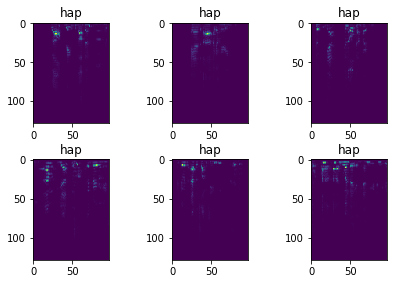

In [146]:
plot_spectrograms(hap['index'].values[:6])

Neutral Plots 

/anaconda/envs/py36/lib/python3.6/site-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


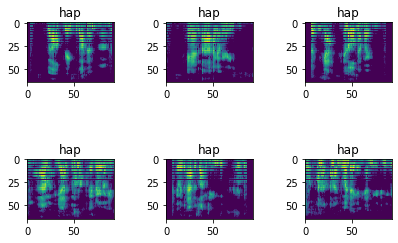

In [147]:
plot_mel_spectrograms(hap['index'].values[:6])

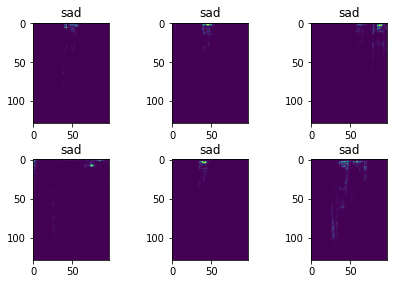

In [148]:
plot_spectrograms(sad['index'].values[:6])

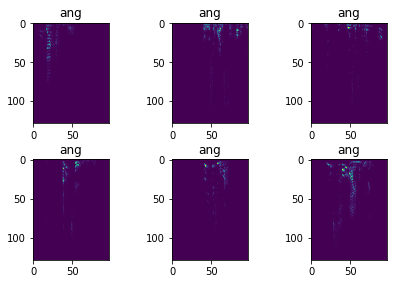

In [149]:
plot_spectrograms(ang['index'].values[:6])

In [150]:
rnn = nn.GRU(128, hidden_size = 64, num_layers=2, bidirectional=True, batch_first=True)
x= torch.from_numpy(get_melspectrogram_db('/data/home/advaitmb/datasets/sentences/' + audio.wav_file[1000] + '.wav', 4 ).T).unsqueeze(0)
print(x.shape)
out, _ = rnn(x)
print(out.reshape(out.size(0), -1).shape)

torch.Size([1, 126, 65])


RuntimeError: input.size(-1) must be equal to input_size. Expected 128, got 65

In [7]:
# We split the dataframe into train and test segments
from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
train = audio[:2212]
train = shuffle(train)
valid = audio[2212:]

# from sklearn.model_selection import train_test_split

# train, valid = train_test_split(audio, test_size=0.2)

In [15]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128,top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

In [18]:
class IEMOCAP(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        print(self.categories)
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            
            #If all files are stored in a folder named sentences
            file_path = base + '/' + row[in_col] + '.wav'
            
            
            self.data.append(( normalize(get_melspectrogram_db(file_path)).T ))
            self.labels.append(self.c2i[row['emotion']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [19]:
train_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', train, 'wav_file', 'emotion')
valid_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', valid, 'wav_file', 'emotion')
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

  0%|          | 7/2212 [00:00<00:32, 67.29it/s]

['ang', 'hap', 'neu', 'sad']


  1%|          | 4/731 [00:00<00:22, 32.29it/s]

['ang', 'hap', 'neu', 'sad']


100%|██████████| 731/731 [00:18<00:00, 38.78it/s]


In [114]:
train_loader.dataset.data[0].shape

(129, 129)

In [48]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(128, hidden_size = 64, num_layers=2, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(64, 4)
        
    def forward(self, x):
        x,(ht,ct) = self.rnn(x)
        x  = ht[-1]
        x = x.reshape(x.size(0), -1)
        x = F.softmax(self.fc1(x), dim=1)
        return x

In [49]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [50]:
net = Network()
net.to(device)

Network(
  (rnn): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)

In [51]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print("Changed learning rate to {}".format(new_lr))
    return optimizer

In [52]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

def train_model(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    
    for epoch in range(1,epochs+1):
        
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in tqdm(enumerate(train_loader)):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)


#         print("Epoch - {} Train-Loss : {}".format(epoch, np.mean(train_losses[-1])))
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())

        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        unweighted_accuracy = accuracy_score( trace_yhat.argmax(axis=1), trace_y )
        weighted_accuracy = balanced_accuracy_score( trace_yhat.argmax(axis=1), trace_y )
        print("Epoch - {} Train-Loss : {} Valid-Loss : {}".format(epoch, np.mean(train_losses[-1]), np.mean(valid_losses[-1])))
        print("unweighted_accuracy : {} weighted_accuracy : {}".format(unweighted_accuracy, weighted_accuracy ))
        




In [53]:
learning_rate = 2e-5
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
epochs = 20
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
valid_losses=[]

In [54]:
train_model(net, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

70it [00:07,  9.83it/s]
1it [00:00,  9.79it/s]

Epoch - 1 Train-Loss : 1.379390229497637 Valid-Loss : 1.3713203720424487
unweighted_accuracy : 0.3898768809849521 weighted_accuracy : 0.3203232462173315


70it [00:06, 10.25it/s]
0it [00:00, ?it/s]

Epoch - 2 Train-Loss : 1.3715014202254159 Valid-Loss : 1.3610354454621025
unweighted_accuracy : 0.39261285909712723 weighted_accuracy : 0.39261285909712723


70it [00:06, 10.17it/s]
0it [00:00, ?it/s]

Epoch - 3 Train-Loss : 1.3620279942240034 Valid-Loss : 1.3494044024011362
unweighted_accuracy : 0.39261285909712723 weighted_accuracy : 0.39261285909712723


70it [00:06, 10.27it/s]
1it [00:00,  9.91it/s]

Epoch - 4 Train-Loss : 1.3515694226537431 Valid-Loss : 1.3366475157115771
unweighted_accuracy : 0.39261285909712723 weighted_accuracy : 0.39261285909712723


70it [00:06, 10.27it/s]
1it [00:00,  9.91it/s]

Epoch - 5 Train-Loss : 1.3409728867667061 Valid-Loss : 1.3236461100370989
unweighted_accuracy : 0.39261285909712723 weighted_accuracy : 0.19657534246575342


70it [00:04, 14.80it/s]
2it [00:00, 18.06it/s]

Epoch - 6 Train-Loss : 1.3312170863151551 Valid-Loss : 1.3141095793765525
unweighted_accuracy : 0.3953488372093023 weighted_accuracy : 0.39765840220385673


70it [00:03, 17.90it/s]
2it [00:00, 18.22it/s]

Epoch - 7 Train-Loss : 1.319600544657026 Valid-Loss : 1.3031876916470735
unweighted_accuracy : 0.39808481532147744 weighted_accuracy : 0.4072206768660176


70it [00:03, 17.91it/s]
2it [00:00, 17.86it/s]

Epoch - 8 Train-Loss : 1.3027797528675624 Valid-Loss : 1.2889784937319548
unweighted_accuracy : 0.4049247606019152 weighted_accuracy : 0.47300936017438133


70it [00:03, 17.97it/s]
2it [00:00, 17.78it/s]

Epoch - 9 Train-Loss : 1.2810862421989442 Valid-Loss : 1.2718461596447488
unweighted_accuracy : 0.42954856361149113 weighted_accuracy : 0.5272443924973562
Changed learning rate to 2.0000000000000003e-06


70it [00:03, 17.84it/s]
2it [00:00, 18.01it/s]

Epoch - 10 Train-Loss : 1.2712035093988692 Valid-Loss : 1.2715195158253545
unweighted_accuracy : 0.426812585499316 weighted_accuracy : 0.5223382608175235


70it [00:03, 17.96it/s]
2it [00:00, 17.82it/s]

Epoch - 11 Train-Loss : 1.2686012898172652 Valid-Loss : 1.270587480586508
unweighted_accuracy : 0.4322845417236662 weighted_accuracy : 0.5343733189887037


70it [00:03, 17.91it/s]
2it [00:00, 17.92it/s]

Epoch - 12 Train-Loss : 1.2654643944331578 Valid-Loss : 1.2693352336468904
unweighted_accuracy : 0.43502051983584133 weighted_accuracy : 0.3609047383193


70it [00:03, 17.92it/s]
2it [00:00, 17.62it/s]

Epoch - 13 Train-Loss : 1.2653548410960607 Valid-Loss : 1.2685020332751067
unweighted_accuracy : 0.44049247606019154 weighted_accuracy : 0.6136496400529182


70it [00:03, 17.88it/s]
2it [00:00, 18.05it/s]

Epoch - 14 Train-Loss : 1.26302045243127 Valid-Loss : 1.267621045527251
unweighted_accuracy : 0.45690834473324216 weighted_accuracy : 0.6450507659742403


70it [00:03, 17.93it/s]
2it [00:00, 17.78it/s]

Epoch - 15 Train-Loss : 1.2629914130483355 Valid-Loss : 1.2667403324790623
unweighted_accuracy : 0.4582763337893297 weighted_accuracy : 0.575336112428912


70it [00:03, 17.86it/s]
2it [00:00, 17.96it/s]

Epoch - 16 Train-Loss : 1.2609470333371844 Valid-Loss : 1.2659765430118726
unweighted_accuracy : 0.4637482900136799 weighted_accuracy : 0.5626930861830192


70it [00:03, 17.96it/s]
2it [00:00, 18.12it/s]

Epoch - 17 Train-Loss : 1.2594610163143702 Valid-Loss : 1.2659111282099849
unweighted_accuracy : 0.4692202462380301 weighted_accuracy : 0.564345505582619


70it [00:03, 17.95it/s]
2it [00:00, 18.08it/s]

Epoch - 18 Train-Loss : 1.2565184320722307 Valid-Loss : 1.2654193536094998
unweighted_accuracy : 0.4719562243502052 weighted_accuracy : 0.5618322373706075


70it [00:03, 17.91it/s]
2it [00:00, 17.89it/s]

Epoch - 19 Train-Loss : 1.2576583572796414 Valid-Loss : 1.2638345023860103
unweighted_accuracy : 0.47058823529411764 weighted_accuracy : 0.5517752570605309
Changed learning rate to 2.0000000000000002e-07


70it [00:03, 17.89it/s]


Epoch - 20 Train-Loss : 1.2561937860080175 Valid-Loss : 1.2641538070595784
unweighted_accuracy : 0.47332421340629277 weighted_accuracy : 0.5551862760342825


In the proposed architecture, we consecutively arranged CL. In the first convolutional layer (C1)
has 16 number of kernels with squire shape of size (7 × 7) are applied to the input spectrogram with has 16 number of kernels with squire shape of size (7 × 7) are applied to the input spectrogram with
the same padding and stride setting of (2 × 2) pixel. Similarly, in the second convolutional layer (C2)
Sensors 2020, 20, 183 7 of 15
the same padding and stride setting of (2 × 2) pixel. Similarly, in the second convolutional layer (C2) it has 32 filters of size (5 × 5) with (2 × 2) stride setting. The C3 layer uses the same number of filters, stride, and padding as C2, but the size of the filters is 3 × 3. C4 and C5 layers have 64 (3 × 3) kernels with a stride setting of 2 × 2 pixels. In the same way, C6 and C7 layers have 128 kernels of size (3 × 3) with the same stride and padding. The last convolutional layer, which is followed by a flattening layer to convert the data shape into vector form and then the features are fed to FC. The first FC layer has 512 neurons and the last FC layer has the same number of neurons as classes

In [192]:
?nn.Dropout

In [152]:
class IEMOCAP(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        print(self.categories)
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            
            #If all files are stored in a folder named sentences
            file_path = base + '/' + row[in_col] + '.wav'
            
            
            self.data.append(( normalize(get_spectrogram_db(file_path, 4))[np.newaxis, ...] ))
            self.labels.append(self.c2i[row['emotion']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [153]:
train_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', train, 'wav_file', 'emotion')
valid_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', valid, 'wav_file', 'emotion')
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

  0%|          | 3/2354 [00:00<01:35, 24.52it/s]

['ang', 'hap', 'neu', 'sad']


  1%|          | 3/589 [00:00<00:22, 25.81it/s]

['ang', 'hap', 'neu', 'sad']


100%|██████████| 589/589 [00:30<00:00, 19.51it/s]


In [55]:
train_data.labels

[1,
 2,
 1,
 1,
 1,
 2,
 3,
 3,
 1,
 1,
 3,
 2,
 1,
 1,
 2,
 3,
 1,
 1,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 1,
 2,
 3,
 0,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 1,
 3,
 2,
 1,
 2,
 3,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 3,
 2,
 2,
 2,
 3,
 1,
 3,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 3,
 3,
 3,
 3,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 3,
 1,
 3,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 3,
 3,
 2,
 2,
 1,
 3,
 1,
 2,
 0,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 3,
 3,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 3,
 0,
 2,
 3,
 2,
 2,
 1,
 1,
 2,
 1,
 0,
 3,
 0,
 2,
 1,
 3,
 3,
 3,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 1,
 3,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 1,
 3,
 3,
 1,
 2,
 2,
 0,
 2,
 3,
 3,
 2,
 1,
 1,
 1,
 3,
 1,
 0,
 3,
 2,
 1,
 3,
 0,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 3,
 3,
 1,
 2,
 3,
 2,


In [154]:
train_loader.dataset.data[1].std()

1.0

In [155]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(7,7), stride=(2,2), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5,5), stride=(2,2), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=(2,2), padding=(1,1))

        self.fc1 = nn.Linear(128, 512)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 4)
    
    def convs(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.bn6(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [156]:
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [106]:
i = torch.randn(64, 1, 129, 129).to(device)
o = cnn(i)

In [157]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

def train_model(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    
    for epoch in range(1,epochs+1):
        
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in tqdm(enumerate(train_loader)):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)


#         print("Epoch - {} Train-Loss : {}".format(epoch, np.mean(train_losses[-1])))
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())

        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        unweighted_accuracy = accuracy_score( trace_yhat.argmax(axis=1), trace_y )
        weighted_accuracy = balanced_accuracy_score( trace_yhat.argmax(axis=1), trace_y )
        print("Epoch - {} Train-Loss : {} Valid-Loss : {}".format(epoch, np.mean(train_losses[-1]), np.mean(valid_losses[-1])))
        print("unweighted_accuracy : {} weighted_accuracy : {}".format(unweighted_accuracy, weighted_accuracy ))
        

In [158]:
learning_rate = 2e-4
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate, weight_decay=0.005)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
valid_losses=[]

In [159]:
train_model(cnn, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

37it [00:01, 30.42it/s]
4it [00:00, 34.44it/s]

Epoch - 1 Train-Loss : 1.3453409381814905 Valid-Loss : 1.3096454739570618
unweighted_accuracy : 0.41256366723259763 weighted_accuracy : 0.46073270305113884


37it [00:01, 34.24it/s]
4it [00:00, 34.74it/s]

Epoch - 2 Train-Loss : 1.2692586827922512 Valid-Loss : 1.2554392337799072
unweighted_accuracy : 0.4634974533106961 weighted_accuracy : 0.5138124499064921


37it [00:01, 34.01it/s]
4it [00:00, 34.76it/s]

Epoch - 3 Train-Loss : 1.1600208701314152 Valid-Loss : 1.2142937898635864
unweighted_accuracy : 0.5059422750424448 weighted_accuracy : 0.5141497208931419


37it [00:01, 34.12it/s]
4it [00:00, 34.73it/s]

Epoch - 4 Train-Loss : 1.0456143069911648 Valid-Loss : 1.2424926042556763
unweighted_accuracy : 0.4685908319185059 weighted_accuracy : 0.46757468640909233


37it [00:01, 34.15it/s]
4it [00:00, 34.74it/s]

Epoch - 5 Train-Loss : 0.9689007900856637 Valid-Loss : 1.2149614214897155
unweighted_accuracy : 0.5025466893039049 weighted_accuracy : 0.5224266310922245


37it [00:01, 34.40it/s]
4it [00:00, 34.74it/s]

Epoch - 6 Train-Loss : 0.9352054257650633 Valid-Loss : 1.230042612552643
unweighted_accuracy : 0.5059422750424448 weighted_accuracy : 0.5072938209678158


37it [00:01, 34.31it/s]
4it [00:00, 34.12it/s]

Epoch - 7 Train-Loss : 0.9118377340806497 Valid-Loss : 1.223758828639984
unweighted_accuracy : 0.5025466893039049 weighted_accuracy : 0.500143815168661


37it [00:01, 34.07it/s]
4it [00:00, 33.20it/s]

Epoch - 8 Train-Loss : 0.9004044564994605 Valid-Loss : 1.234082579612732
unweighted_accuracy : 0.48896434634974534 weighted_accuracy : 0.48887457822677477


37it [00:01, 33.94it/s]
4it [00:00, 34.01it/s]

Epoch - 9 Train-Loss : 0.8898195318273596 Valid-Loss : 1.235209596157074
unweighted_accuracy : 0.499151103565365 weighted_accuracy : 0.5003524397336736
Changed learning rate to 2e-05


37it [00:01, 33.86it/s]
4it [00:00, 34.11it/s]

Epoch - 10 Train-Loss : 0.8820268882287515 Valid-Loss : 1.2210898637771606
unweighted_accuracy : 0.48896434634974534 weighted_accuracy : 0.49020034555982006


37it [00:01, 33.90it/s]
4it [00:00, 33.27it/s]

Epoch - 11 Train-Loss : 0.8799476510769612 Valid-Loss : 1.2214874267578124
unweighted_accuracy : 0.49745331069609505 weighted_accuracy : 0.5001470264128973


37it [00:01, 33.65it/s]
4it [00:00, 33.87it/s]

Epoch - 12 Train-Loss : 0.8784925099965688 Valid-Loss : 1.2219504237174987
unweighted_accuracy : 0.49745331069609505 weighted_accuracy : 0.5013109199155711


37it [00:01, 33.98it/s]
4it [00:00, 33.97it/s]

Epoch - 13 Train-Loss : 0.8775085339675078 Valid-Loss : 1.2304375052452088
unweighted_accuracy : 0.4923599320882852 weighted_accuracy : 0.495339945967561


37it [00:01, 34.12it/s]
4it [00:00, 33.35it/s]

Epoch - 14 Train-Loss : 0.8763899142677719 Valid-Loss : 1.237543249130249
unweighted_accuracy : 0.49745331069609505 weighted_accuracy : 0.4985380116959064


37it [00:01, 33.98it/s]
4it [00:00, 34.59it/s]

Epoch - 15 Train-Loss : 0.8754396390270542 Valid-Loss : 1.2396594047546388
unweighted_accuracy : 0.5008488964346349 weighted_accuracy : 0.5030434263687082


37it [00:01, 34.17it/s]
4it [00:00, 33.73it/s]

Epoch - 16 Train-Loss : 0.8735303540487547 Valid-Loss : 1.2392624020576477
unweighted_accuracy : 0.4923599320882852 weighted_accuracy : 0.49818456449280824


37it [00:01, 34.28it/s]
4it [00:00, 33.84it/s]

Epoch - 17 Train-Loss : 0.8730696439743042 Valid-Loss : 1.2312031030654906
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.5005413753264621


37it [00:01, 33.70it/s]
4it [00:00, 34.52it/s]

Epoch - 18 Train-Loss : 0.8718327670483976 Valid-Loss : 1.2079991757869721
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.49775209717581387


37it [00:01, 34.11it/s]
4it [00:00, 33.14it/s]

Epoch - 19 Train-Loss : 0.8713481361801559 Valid-Loss : 1.2318284153938293
unweighted_accuracy : 0.499151103565365 weighted_accuracy : 0.5015944919255043
Changed learning rate to 2e-06


37it [00:01, 33.67it/s]
4it [00:00, 33.94it/s]

Epoch - 20 Train-Loss : 0.8706146526981045 Valid-Loss : 1.2263845086097718
unweighted_accuracy : 0.49745331069609505 weighted_accuracy : 0.4993546265589612


37it [00:01, 34.03it/s]
4it [00:00, 34.47it/s]

Epoch - 21 Train-Loss : 0.8699357509613037 Valid-Loss : 1.2406354904174806
unweighted_accuracy : 0.4923599320882852 weighted_accuracy : 0.49502612173478316


37it [00:01, 33.90it/s]
4it [00:00, 34.25it/s]

Epoch - 22 Train-Loss : 0.8698877160613602 Valid-Loss : 1.2431151390075683
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.4982618275721724


37it [00:01, 34.23it/s]
4it [00:00, 34.85it/s]

Epoch - 23 Train-Loss : 0.8694132276483484 Valid-Loss : 1.2327298998832703
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.49975452546610044


37it [00:01, 33.92it/s]
4it [00:00, 33.88it/s]

Epoch - 24 Train-Loss : 0.8696073390342094 Valid-Loss : 1.2324503183364868
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.5027919501133787


37it [00:01, 33.73it/s]
4it [00:00, 34.48it/s]

Epoch - 25 Train-Loss : 0.8698051587955372 Valid-Loss : 1.2224130511283875
unweighted_accuracy : 0.48896434634974534 weighted_accuracy : 0.4936640886985308


37it [00:01, 34.11it/s]
4it [00:00, 34.27it/s]

Epoch - 26 Train-Loss : 0.8693324649656141 Valid-Loss : 1.2477655172348023
unweighted_accuracy : 0.4940577249575552 weighted_accuracy : 0.4978216947348046


37it [00:01, 33.69it/s]
4it [00:00, 34.42it/s]

Epoch - 27 Train-Loss : 0.8691611950461929 Valid-Loss : 1.2276876449584961
unweighted_accuracy : 0.4906621392190153 weighted_accuracy : 0.49479281466953084


37it [00:01, 34.04it/s]
4it [00:00, 33.72it/s]

Epoch - 28 Train-Loss : 0.8691168846310796 Valid-Loss : 1.2407033801078797
unweighted_accuracy : 0.4940577249575552 weighted_accuracy : 0.5000944248090868


37it [00:01, 33.72it/s]
4it [00:00, 34.33it/s]

Epoch - 29 Train-Loss : 0.8691927613438787 Valid-Loss : 1.2260478138923645
unweighted_accuracy : 0.4906621392190153 weighted_accuracy : 0.4938819192833334
Changed learning rate to 2.0000000000000002e-07


37it [00:01, 34.21it/s]
4it [00:00, 34.04it/s]

Epoch - 30 Train-Loss : 0.8683810475710276 Valid-Loss : 1.2226621985435486
unweighted_accuracy : 0.49745331069609505 weighted_accuracy : 0.5011062771248187


37it [00:01, 33.81it/s]
4it [00:00, 34.49it/s]

Epoch - 31 Train-Loss : 0.8696568318315454 Valid-Loss : 1.2261142134666443
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.5013067149170848


37it [00:01, 34.23it/s]
4it [00:00, 34.66it/s]

Epoch - 32 Train-Loss : 0.8690675368180146 Valid-Loss : 1.219163966178894
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.4981693301189071


37it [00:01, 33.64it/s]
4it [00:00, 34.19it/s]

Epoch - 33 Train-Loss : 0.8689585569742564 Valid-Loss : 1.2338753819465638
unweighted_accuracy : 0.4940577249575552 weighted_accuracy : 0.4988666861855268


37it [00:01, 34.09it/s]
4it [00:00, 34.25it/s]

Epoch - 34 Train-Loss : 0.868686015541489 Valid-Loss : 1.222920823097229
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.5010289363871087


37it [00:01, 33.85it/s]
4it [00:00, 34.44it/s]

Epoch - 35 Train-Loss : 0.8680626492242556 Valid-Loss : 1.2460356593132018
unweighted_accuracy : 0.49745331069609505 weighted_accuracy : 0.5014892912577419


37it [00:01, 34.07it/s]
4it [00:00, 34.41it/s]

Epoch - 36 Train-Loss : 0.8688857281530226 Valid-Loss : 1.22958984375
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.5018447018447018


37it [00:01, 33.98it/s]
4it [00:00, 34.58it/s]

Epoch - 37 Train-Loss : 0.8687639929152824 Valid-Loss : 1.2363452434539794
unweighted_accuracy : 0.4923599320882852 weighted_accuracy : 0.49759177137225913


37it [00:01, 34.09it/s]
4it [00:00, 34.33it/s]

Epoch - 38 Train-Loss : 0.8688270610732001 Valid-Loss : 1.2406872868537904
unweighted_accuracy : 0.48896434634974534 weighted_accuracy : 0.49545644086738366


37it [00:01, 33.89it/s]
4it [00:00, 34.28it/s]

Epoch - 39 Train-Loss : 0.8694791826041969 Valid-Loss : 1.2255617141723634
unweighted_accuracy : 0.499151103565365 weighted_accuracy : 0.5030610911758453
Changed learning rate to 2e-08


37it [00:01, 34.05it/s]
4it [00:00, 34.22it/s]

Epoch - 40 Train-Loss : 0.8686832914481292 Valid-Loss : 1.2321603894233704
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.4963859963859964


37it [00:01, 34.11it/s]
4it [00:00, 34.20it/s]

Epoch - 41 Train-Loss : 0.868989511116131 Valid-Loss : 1.2290856838226318
unweighted_accuracy : 0.49745331069609505 weighted_accuracy : 0.49991001353475983


37it [00:01, 33.29it/s]
4it [00:00, 34.07it/s]

Epoch - 42 Train-Loss : 0.8688322724522771 Valid-Loss : 1.2311545372009278
unweighted_accuracy : 0.4940577249575552 weighted_accuracy : 0.4970159690522708


37it [00:01, 33.78it/s]
4it [00:00, 34.35it/s]

Epoch - 43 Train-Loss : 0.8688723106642027 Valid-Loss : 1.241838777065277
unweighted_accuracy : 0.4923599320882852 weighted_accuracy : 0.4972542421734824


37it [00:01, 33.69it/s]
4it [00:00, 34.68it/s]

Epoch - 44 Train-Loss : 0.8687630215206662 Valid-Loss : 1.2228338122367859
unweighted_accuracy : 0.49745331069609505 weighted_accuracy : 0.500320781100615


37it [00:01, 34.02it/s]
4it [00:00, 34.32it/s]

Epoch - 45 Train-Loss : 0.868594052018346 Valid-Loss : 1.225698959827423
unweighted_accuracy : 0.5008488964346349 weighted_accuracy : 0.5041791044776119


37it [00:01, 33.89it/s]
4it [00:00, 33.70it/s]

Epoch - 46 Train-Loss : 0.8691067921148764 Valid-Loss : 1.225554096698761
unweighted_accuracy : 0.4923599320882852 weighted_accuracy : 0.49506775820793436


37it [00:01, 34.00it/s]
4it [00:00, 34.70it/s]

Epoch - 47 Train-Loss : 0.8695275445242185 Valid-Loss : 1.235040831565857
unweighted_accuracy : 0.48896434634974534 weighted_accuracy : 0.493100357122411


37it [00:01, 33.98it/s]
4it [00:00, 33.75it/s]

Epoch - 48 Train-Loss : 0.8685110098606831 Valid-Loss : 1.2254974365234375
unweighted_accuracy : 0.4906621392190153 weighted_accuracy : 0.49435726498389077


37it [00:01, 33.77it/s]
4it [00:00, 34.69it/s]

Epoch - 49 Train-Loss : 0.8687886966241373 Valid-Loss : 1.2437508702278137
unweighted_accuracy : 0.4940577249575552 weighted_accuracy : 0.49844733592361673
Changed learning rate to 2e-09


37it [00:01, 33.57it/s]


Epoch - 50 Train-Loss : 0.8693640989226263 Valid-Loss : 1.220603835582733
unweighted_accuracy : 0.49575551782682514 weighted_accuracy : 0.4994334147025916


In [66]:
nice_train = train
nice_valid = valid

In [237]:
# from sklearn.model_selection import train_test_split
# train, valid = train_test_split(audio, test_size=0.2)
from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
train = audio[:2617]
train = shuffle(train)
valid = audio[2617:]
# train = nice_train
# valid = nice_valid

In [281]:

def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128,top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [282]:
get_melspectrogram_db('/data/home/advaitmb/datasets/sentences/' + audio['wav_file'][1] + '.wav').shape

(128, 157)

In [64]:


class IEMOCAP(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        print(self.categories)
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = base + '/' + row[in_col] + '.wav'
            self.data.append(normalize(get_melspectrogram_db(file_path))[np.newaxis,...])
            self.labels.append(self.c2i[row['emotion']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [72]:
train_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', train, 'wav_file', 'emotion')
valid_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', valid, 'wav_file', 'emotion')
train_loader = DataLoader(train_data, batch_size=128, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False)

  0%|          | 11/2212 [00:00<00:21, 103.81it/s]

['ang', 'hap', 'neu', 'sad']


  2%|▏         | 11/731 [00:00<00:07, 101.61it/s]

['ang', 'hap', 'neu', 'sad']


100%|██████████| 731/731 [00:07<00:00, 103.51it/s]


In [346]:
l = nn.GRU(128*7, 64, 1, bidirectional=False)
f = nn.Linear()
#torch.Size([32, 128, 7, 8])
i = torch.randn(32, 128, 7, 8)
i = i.permute(0, 3, 1, 2)
i = i.reshape(i.shape[0], i.shape[1], i.shape[2]*i.shape[3])
o, _ = l(i)
o.shape

torch.Size([32, 8, 64])

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRNN(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5, 2, padding=1) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 2, padding=1) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 5, 2, padding=1)
        
        self.fc1 = nn.Linear((7*8*128), 512) #flattening.
        
        
        self.fc2 = nn.Linear(512, 4) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


crnn = CRNN()
print(crnn)

CRNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=7168, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [74]:
crnn.to(device)

CRNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=7168, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [75]:
# i = torch.randn(32, 1, 129, 157).to(device)
# o = crnn(i)

In [76]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print("Changed learning rate to {}".format(new_lr))
    return optimizer

In [77]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

def train_model(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    
    for epoch in range(1,epochs+1):
        
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in tqdm(enumerate(train_loader)):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)


#         print("Epoch - {} Train-Loss : {}".format(epoch, np.mean(train_losses[-1])))
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())

        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        unweighted_accuracy = accuracy_score( trace_yhat.argmax(axis=1), trace_y )
        weighted_accuracy = balanced_accuracy_score( trace_yhat.argmax(axis=1), trace_y )
        print("Epoch - {} Train-Loss : {} Valid-Loss : {}".format(epoch, np.mean(train_losses[-1]), np.mean(valid_losses[-1])))
        print("unweighted_accuracy : {} weighted_accuracy : {}".format(unweighted_accuracy, weighted_accuracy ))
        

In [78]:
learning_rate = 2e-4
optimizer = optim.Adam(crnn.parameters(), lr=learning_rate, weight_decay=0.005)
epochs = 8
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
valid_losses=[]

In [79]:
train_model(crnn, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

18it [00:02,  6.67it/s]
1it [00:00,  6.64it/s]

Epoch - 1 Train-Loss : 1.219491548008389 Valid-Loss : 1.401651402314504
unweighted_accuracy : 0.20383036935704515 weighted_accuracy : 0.35856583455702395


18it [00:02,  6.91it/s]
1it [00:00,  6.54it/s]

Epoch - 2 Train-Loss : 1.0993236502011616 Valid-Loss : 1.1999614238739014
unweighted_accuracy : 0.521203830369357 weighted_accuracy : 0.5528281161836185


18it [00:02,  6.88it/s]
1it [00:00,  6.61it/s]

Epoch - 3 Train-Loss : 1.0396446519427829 Valid-Loss : 1.1500777403513591
unweighted_accuracy : 0.5937072503419972 weighted_accuracy : 0.5988090103043374


18it [00:02,  6.91it/s]
1it [00:00,  6.62it/s]

Epoch - 4 Train-Loss : 1.0183185736338298 Valid-Loss : 1.217254102230072
unweighted_accuracy : 0.518467852257182 weighted_accuracy : 0.6057318869693318


18it [00:02,  6.90it/s]
1it [00:00,  6.63it/s]

Epoch - 5 Train-Loss : 0.9966554575496249 Valid-Loss : 1.158712367216746
unweighted_accuracy : 0.5786593707250342 weighted_accuracy : 0.5941381293059407


18it [00:02,  6.88it/s]
1it [00:00,  6.56it/s]

Epoch - 6 Train-Loss : 0.9374294877052307 Valid-Loss : 1.140179435412089
unweighted_accuracy : 0.6046511627906976 weighted_accuracy : 0.6192080328888147


18it [00:02,  6.90it/s]
1it [00:00,  6.66it/s]

Epoch - 7 Train-Loss : 0.9146534436278873 Valid-Loss : 1.1452919443448384
unweighted_accuracy : 0.5909712722298222 weighted_accuracy : 0.6105718537414967


18it [00:02,  6.88it/s]


Epoch - 8 Train-Loss : 0.9009284973144531 Valid-Loss : 1.1411031087239583
unweighted_accuracy : 0.585499316005472 weighted_accuracy : 0.6185183701085945


In [189]:
resnet_train_losses

[]

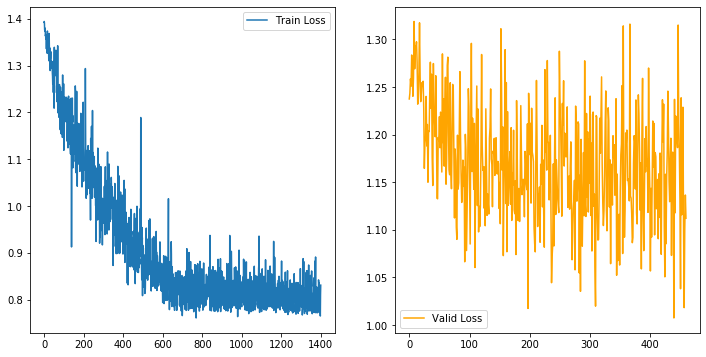

In [77]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])